<a href="https://colab.research.google.com/github/NelaRepko/NelaRepko-GoIT_hw_Python/blob/main/goit_hw_ABtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving _ab_test_data.csv to _ab_test_data (1).csv


In [2]:
uploaded.keys()

dict_keys(['_ab_test_data (1).csv'])

In [3]:
import numpy as np
import pandas as pd
df_ab_test = pd.read_csv("_ab_test_data.csv")

In [4]:
df_ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19998 entries, 0 to 19997
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     19998 non-null  object
 1   timestamp   19998 non-null  object
 2   test_group  19998 non-null  object
 3   conversion  19998 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 625.1+ KB


In [5]:
# к-сть рядків у кожному з тестів
users = df_ab_test["test_group"].value_counts()
print(users)

test_group
a    10013
b     9985
Name: count, dtype: int64


In [6]:
# к-сть унікальних юзерів у кожному з тестів
uniq_users = df_ab_test.groupby("test_group")["user_id"].nunique()
print(uniq_users)

test_group
a    10013
b     9985
Name: user_id, dtype: int64


In [7]:
# к-сть конверсій у кожній з груп
conversions = df_ab_test.groupby("test_group")["conversion"].sum()
print(conversions)

test_group
a    611
b    889
Name: conversion, dtype: int64


In [8]:
# рівень конверсії по групах
conversion_rate = conversions / users
print(conversion_rate)

test_group
a    0.061021
b    0.089034
dtype: float64


In [9]:
# Дата початку / кінця тесту, тривалість тесту в днях
df_ab_test["timestamp"] = pd.to_datetime(df_ab_test["timestamp"])

start_date = df_ab_test["timestamp"].min()
end_date   = df_ab_test["timestamp"].max()

print("Start date:", start_date)
print("End date:", end_date)

duration = end_date - start_date
print("Test duration:", duration)
print("Duration in days:", duration.days)

Start date: 2023-07-03 01:42:34.033708
End date: 2023-07-25 01:41:19.152664
Test duration: 21 days 23:58:45.118956
Duration in days: 21


In [10]:
# обираю Z-тест для двох пропорцій (Two-proportion z-test)
# H0 гіпотеза: рівні конверсії в групах A і B однакові
# H1 / альтернативна гіпотеза: рівні конверсії різні
from statsmodels.stats.proportion import proportions_ztest

successes = conversions.values
mumbers = users.values

z_stat, p_value = proportions_ztest(successes, mumbers, alternative='two-sided')
z_stat, p_value

(np.float64(-7.519675939906207), np.float64(5.491217728445103e-14))

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipython-input-2749179311.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='group', y='conversion_rate', data=plot_df, ci=None, palette=['skyblue', 'salmon'])
/tmp/ipython-input-2749179311.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='group', y='conversion_rate', data=plot_df, ci=None, palette=['skyblue', 'salmon'])


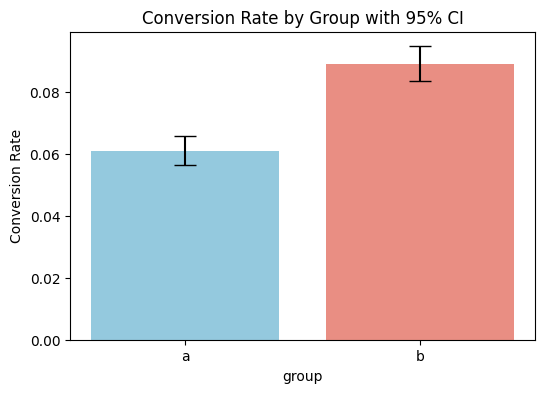

In [13]:
groups = conversion_rate.index.tolist()          # ['a', 'b']
means = conversion_rate.values                  # [rate_a, rate_b]
n = users.values                                # [n_a, n_b]

# стандартна помилка
se = np.sqrt(means * (1 - means) / n)

# 95% довірчі інтервали
ci_lower = means - 1.96 * se
ci_upper = means + 1.96 * se

plot_df = pd.DataFrame({
    'group': groups,
    'conversion_rate': means,
    'ci_lower': ci_lower,
    'ci_upper': ci_upper
})

plt.figure(figsize=(6,4))
sns.barplot(x='group', y='conversion_rate', data=plot_df, ci=None, palette=['skyblue', 'salmon'])

# додаємо error bars вручну
plt.errorbar(x=np.arange(len(plot_df)),
             y=plot_df['conversion_rate'],
             yerr=1.96*se,
             fmt='none',
             capsize=8,
             color='black')

plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Group with 95% CI')
plt.show()

Висновки:
Z-статистика у модулі дуже велика (-7.52), що означає, що спостережувана різниця між групами суттєво відрізняється від нульової.
p-value надзвичайно мале (5.49×10^-14), що значно менше стандартного рівня значущості α = 0.05.
Рівень конверсії в групах статистично значуще відрізняється.
Можна стверджувати, що зміни у групі B вплинули на конверсію порівняно з групою A.

Базуючись на цих даних ми відхиляємо нульову гіпотезу та приймаємо альтернативний варіант до імплементації.